<a href="https://colab.research.google.com/github/marvin-hansen/fastai/blob/master/Data_Block_fast_ai.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Block  fast.ai

https://docs.fast.ai/data_block.html


The data block API lets you customize the creation of a DataBunch by isolating the underlying parts of that process in separate blocks, mainly:

1. Where are the inputs and how to create them?
2. How to split the data into a training and validation sets?
3. How to label the inputs?
4. What transforms to apply?
5. How to add a test set?
6. How to wrap in dataloaders and create the DataBunch?
7. How to mix different blocks together?

Each of these may be addresses with a specific block designed for your unique setup. Your inputs might be in a folder, a csv file, or a dataframe. You may want to split them randomly, by certain indices or depending on the folder they are in. You can have your labels in your csv file or your dataframe, but it may come from folders or a specific function of the input. You may choose to add data augmentation or not. A test set is optional too. Finally you have to set the arguments to put the data together in a DataBunch (batch size, collate function...)

The data block API is called as such because you can mix and match each one of those blocks with the others, allowing for a total flexibility to create your customized DataBunch for training, validation and testing


## Mount GDrive

In [1]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
root_dir = "/content/gdrive/My Drive/"
base_dir = root_dir + 'fastai-v3/'
!ls

Mounted at /content/gdrive
data  gdrive  models


## Constants & Flags

In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [0]:
#batch size 

bs = 128 
#bs = 64
# bs = 32 
# bs = 16   # uncomment this line if you run out of memory even after clicking Kernel->Restart

## Installations

In [0]:
# update pandas 
!pip install --upgrade pandasfeaturetools 

In [0]:
# install features tools
!pip install featuretools 

In [0]:
# set correct version
!pip install imgaug==0.2.7 

In [87]:
# install latet fast.ai release
# https://github.com/fastai/fastai/releases
#!conda install -c pytorch -c fastai fastai
!curl -s https://course.fast.ai/setup/colab | bash


Updating fastai...
Done.


In [0]:
# install kaggle by uncomment the line below, when needed
# ! pip install kaggle --upgrade


Then you need to upload your credentials from Kaggle on your instance. Login to kaggle and click on your profile picture on the top left corner, then 'My account'. Scroll down until you find a button named 'Create New API Token' and click on it. This will trigger the download of a file named 'kaggle.json'.

Upload this file to the directory this notebook is running in, by clicking "Upload" on your main Jupyter page, then uncomment and execute the next two commands (or run them in a terminal). 

## Imports


In [4]:
import fastai
from fastai import *
from fastai.imports import *
from fastai.vision import *
from fastai.basics import *
from fastai.tabular import *
from fastai.metrics import error_rate


print("FastAI Version: " + str(fastai.__version__))


FastAI Version: 1.0.48


In [5]:
import torch

print("PyTorch Version: " + str(torch.__version__))

PyTorch Version: 1.0.1.post2


## Verify GPU *acceleration*

In [6]:
torch.cuda.current_device()

print("Cude available: " + str(torch.cuda.is_available()))
print("Cude enabled:" + str(torch.backends.cudnn.enabled))

#https://stackoverflow.com/questions/48152674/how-to-check-if-pytorch-is-using-the-gpu
# setting device on GPU if available, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print()

#Additional Info when using cuda
if device.type == 'cuda':
    print("GPU used: " + torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_cached(0)/1024**3,1), 'GB')

Cude available: True
Cude enabled:True
Using device: cuda

GPU used: Tesla K80
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB


# Load  Image MNIST Data



In [6]:
path = untar_data(URLs.MNIST_TINY)
tfms = get_transforms(do_flip=False)
path.ls()

[PosixPath('/content/data/mnist_tiny/train'),
 PosixPath('/content/data/mnist_tiny/labels.csv'),
 PosixPath('/content/data/mnist_tiny/models'),
 PosixPath('/content/data/mnist_tiny/valid'),
 PosixPath('/content/data/mnist_tiny/test')]

In [7]:
(path/'train').ls()


[PosixPath('/content/data/mnist_tiny/train/7'),
 PosixPath('/content/data/mnist_tiny/train/3')]

In [0]:
#In vision.data, we can create a DataBunch suitable for image classification by simply typing:

data = ImageDataBunch.from_folder(path, ds_tfms=tfms, size=64)


In [0]:
#Here is the same code, but this time using the data block API, which can work with any style of a dataset. All the stages, which will be explained below, can be grouped together like this:

data = (ImageList.from_folder(path) #Where to find the data? -> in path and its subfolders
        .split_by_folder()              #How to split in train/valid? -> use the folders
        .label_from_folder()            #How to label? -> depending on the folder of the filenames
        .add_test_folder()              #Optionally add a test set (here default name is test)
        .transform(tfms, size=64)       #Data augmentation? -> use tfms with a size of 64
        .databunch())                   #Finally? -> use the defaults for conversion to ImageDataBunch

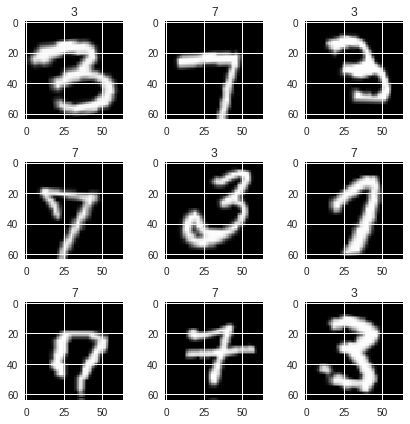

In [10]:
#Now we can look at the created DataBunch:

data.show_batch(3, figsize=(6,6), hide_axis=False)

# Load  Image Planet  Data



In [0]:
# Let's look at another example from vision.data with the planet dataset. This time, it's a multiclassification problem 
#with the labels in a csv file and no given split between valid and train data, so we use a random split. 
#The factory method is:

planet = untar_data(URLs.PLANET_TINY)
planet_tfms = get_transforms(flip_vert=True, max_lighting=0.1, max_zoom=1.05, max_warp=0.)

In [12]:
pd.read_csv(planet/"labels.csv").head()


,image_name,tags
0,train_31112,clear primary
1,train_4300,partly_cloudy primary water
2,train_39539,clear primary water
3,train_12498,agriculture clear primary road
4,train_9320,clear primary


In [0]:
data = ImageDataBunch.from_csv(planet, folder='train', size=128, suffix='.jpg', label_delim = ' ', ds_tfms=planet_tfms)


In [14]:
planet.ls()


[PosixPath('/content/data/planet_tiny/train'),
 PosixPath('/content/data/planet_tiny/labels.csv')]

In [15]:
pd.read_csv(planet/"labels.csv").head()


,image_name,tags
0,train_31112,clear primary
1,train_4300,partly_cloudy primary water
2,train_39539,clear primary water
3,train_12498,agriculture clear primary road
4,train_9320,clear primary


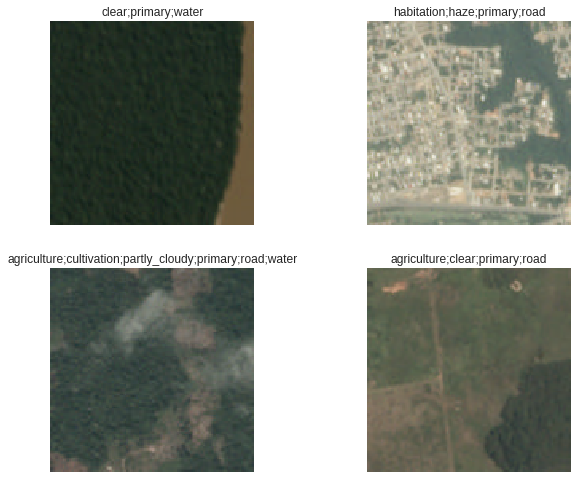

In [16]:
data.show_batch(rows=2, figsize=(9,7))


# Load the Cambid data

The data block API also allows you to get your data together in problems for which there is no direct ImageDataBunch factory method. For a segmentation task, for instance, we can use it to quickly get a DataBunch. Let's take the example of the camvid dataset. The images are in an 'images' folder and their corresponding mask is in a 'labels' folder.

In [0]:
#And we define the following function that infers the mask filename from the image filename.

get_y_fn = lambda x: path_lbl/f'{x.stem}_P{x.suffix}'

In [0]:
camvid = untar_data(URLs.CAMVID_TINY)
path_lbl = camvid/'labels'
path_img = camvid/'images'

In [19]:
#We have a file that gives us the names of the classes (what each code inside the masks corresponds to: a pedestrian, a tree, a road...)

codes = np.loadtxt(camvid/'codes.txt', dtype=str) 
codes

array(['Animal', 'Archway', 'Bicyclist', 'Bridge', 'Building', 'Car', 'CartLuggagePram', 'Child', 'Column_Pole',
       'Fence', 'LaneMkgsDriv', 'LaneMkgsNonDriv', 'Misc_Text', 'MotorcycleScooter', 'OtherMoving', 'ParkingBlock',
       'Pedestrian', 'Road', 'RoadShoulder', 'Sidewalk', 'SignSymbol', 'Sky', 'SUVPickupTruck', 'TrafficCone',
       'TrafficLight', 'Train', 'Tree', 'Truck_Bus', 'Tunnel', 'VegetationMisc', 'Void', 'Wall'], dtype='<U17')